<a href="https://colab.research.google.com/github/sarthakp123chaudhary/sarthakp123chaudhary/blob/main/Plantdis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install split-folders

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [4]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tabulate import tabulate
import os
import numpy as np
import pandas as pd
import random

In [6]:
BATCH_SIZE = 32
IMG_SIZE = 256
EPOCHS = 24

In [7]:
prj_dir = '/content/drive/MyDrive/ColabNotebooks/plantpat'

In [10]:
ds = tf.keras.utils.image_dataset_from_directory(
    prj_dir,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True
)

Found 2152 files belonging to 3 classes.


In [11]:
class_names = ds.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [12]:
from google.colab.patches import cv2_imshow

Batch 1 Imgs shape: (32, 256, 256, 3)
Batch 1 Lbls: [1 1 0 0 0 0 0 1 1 0 1 1 0 1 1 1 1 0 1 0 1 0 1 1 2 0 0 0 1 0 1 1]


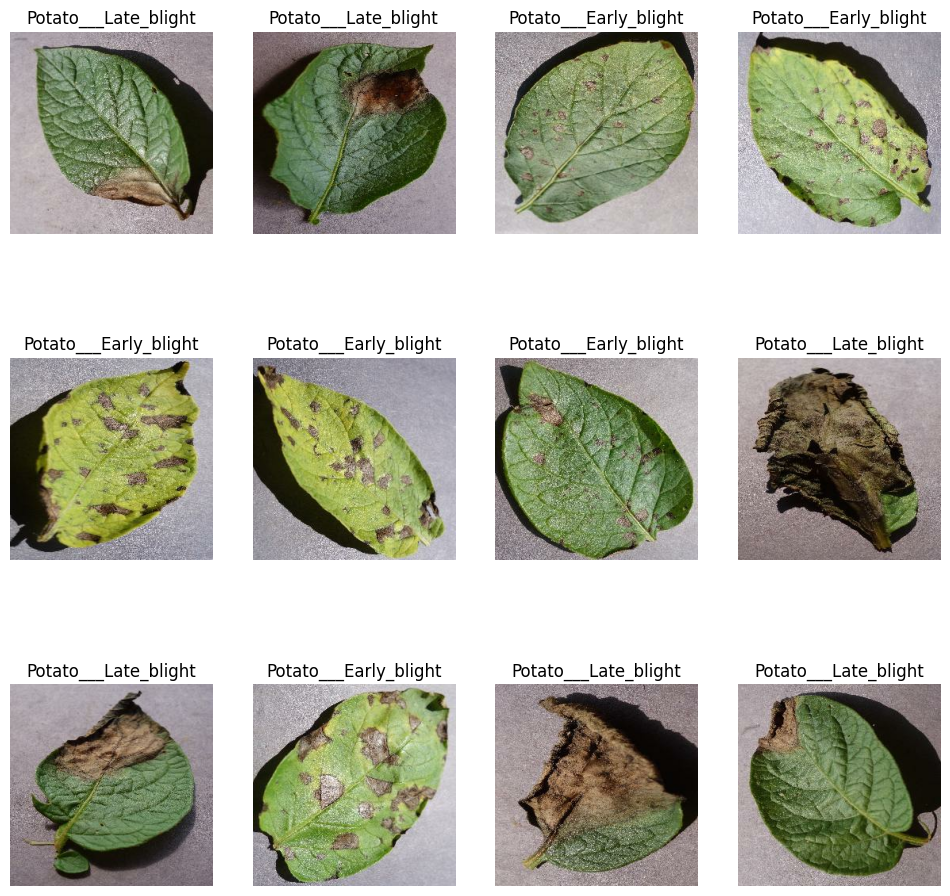

In [13]:
img = None

plt.figure(figsize=(12, 12))

for imgs, lbls in ds.take(1):
    print(f'Batch 1 Imgs shape: {imgs.shape}')
    print(f'Batch 1 Lbls: {lbls.numpy()}')

    img = imgs[0].numpy().astype('uint8') # taking sample image

    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(imgs[i].numpy().astype('uint8'))
        plt.title(class_names[lbls[i]])
        plt.axis('off')

In [14]:
ds_size = len(ds)

ds = ds.shuffle(10000, seed=12)

# taking 10% for testing set and dividing remaining into 80/20 training/validation ratio
train_size = int(ds_size * 0.72) # 72%
train_set = ds.take(train_size)

val_size = int(ds_size * 0.18) # 18%
val_set = ds.skip(train_size).take(val_size)

test_set = ds.skip(train_size).skip(val_size)
test_size = len(test_set) # 10%

print(f'Dataset size   : {ds_size}')
print(f'Train set size : {train_size}')
print(f'Val set size   : {val_size}')
print(f'Test set size  : {test_size}')

Dataset size   : 68
Train set size : 48
Val set size   : 12
Test set size  : 8


In [15]:
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE), # during prediction
    layers.experimental.preprocessing.Rescaling(1.0 / 255) # rescaling rgb values to between 0.0 and 1.0
])

In [17]:
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

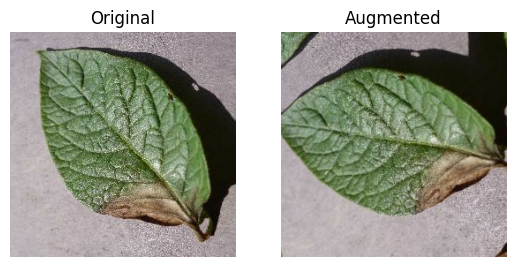

In [18]:
imgs = [img, data_aug(img).numpy().astype('uint8')]
titles = ['Original', 'Augmented']
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(imgs[i])
    plt.title(titles[i])
    plt.axis('off')

In [19]:
train_set = train_set.map(
    lambda x, y: (data_aug(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3) # 3 channels - rgb
n_classes = len(class_names)

model = models.Sequential([
    resize_rescale, # layers.InputLayer(input_shape=input_shape) # using data generator
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=n_classes, activation='softmax')
])

In [21]:
model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

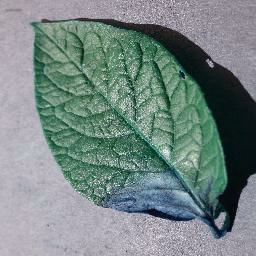

In [24]:
from google.colab.patches import cv2_imshow
cv2_imshow(imgs[0])

In [25]:
# fff = []
# ttt = []

# # Iterate through the dataset and extract images and labels
# for feature_bat, target_bat in train_set:
#     fff.extend(feature_bat.numpy())
#     ttt.extend(target_bat.numpy())

# # Convert lists to numpy arrays
# feature_array = np.array(fff)
# target_array = np.array(fff)
# label_binarizer = LabelBinarizer()
# image_labels2 = label_binarizer.fit_transform(ttt)
# pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
# #n_classes = len(label_binarizer.classes_)

In [27]:
history = model.fit( # using data generator
    train_set, # train_data_gen
    epochs=24, # , steps_per_epoch=train_imgs / BATCH_SIZE
    batch_size=BATCH_SIZE,
    #callbacks=[cp_callback],
    validation_data=val_set, # validation_data=val_data_gen, validation_steps=val_imgs / BATCH_SIZE
    verbose=1
)

Epoch 1/24
48/48 [==============================] - 221s 5s/step - loss: 0.8819 - accuracy: 0.4935 - val_loss: 0.8056 - val_accuracy: 0.6667
Epoch 2/24
48/48 [==============================] - 222s 5s/step - loss: 0.5622 - accuracy: 0.7526 - val_loss: 0.3838 - val_accuracy: 0.8255
Epoch 3/24
48/48 [==============================] - 222s 5s/step - loss: 0.3624 - accuracy: 0.8424 - val_loss: 0.2698 - val_accuracy: 0.8854
Epoch 4/24
48/48 [==============================] - 231s 5s/step - loss: 0.2958 - accuracy: 0.8841 - val_loss: 0.1678 - val_accuracy: 0.9271
Epoch 5/24
48/48 [==============================] - 215s 4s/step - loss: 0.4352 - accuracy: 0.8275 - val_loss: 0.2880 - val_accuracy: 0.8828
Epoch 6/24
48/48 [==============================] - 243s 5s/step - loss: 0.2909 - accuracy: 0.8783 - val_loss: 0.1833 - val_accuracy: 0.9297
Epoch 7/24
48/48 [==============================] - 223s 5s/step - loss: 0.1837 - accuracy: 0.9251 - val_loss: 0.2213 - val_accuracy: 0.9115
Epoch 8/24
48

In [28]:
# getting metrics at every epoch
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

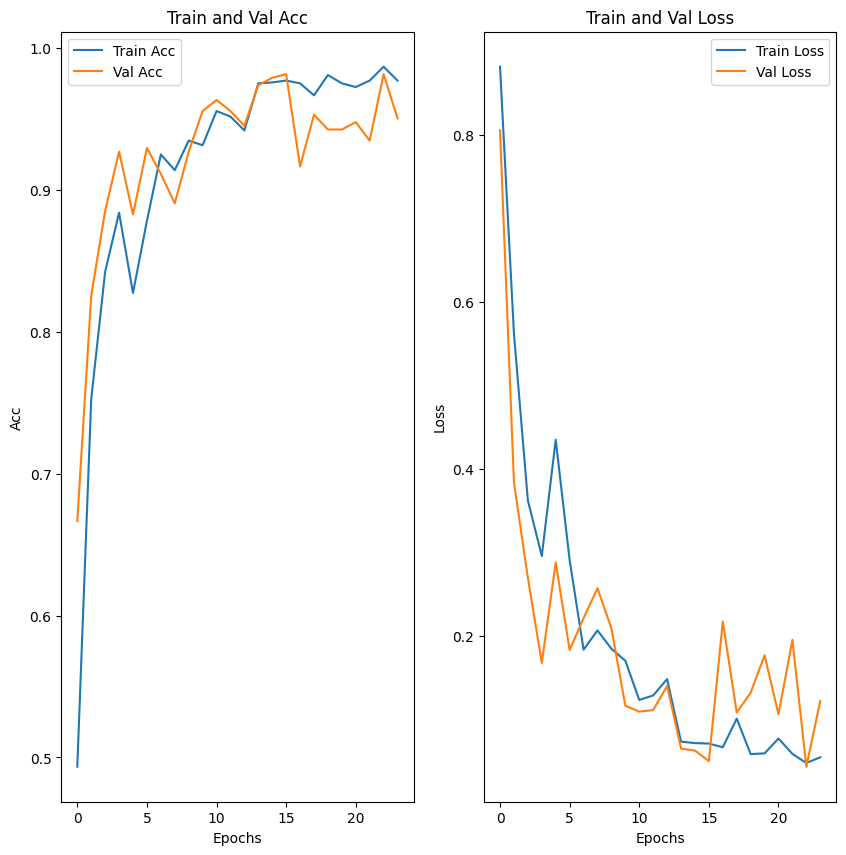

In [29]:
train_metrics = [train_acc, train_loss]
val_metrics = [val_acc, val_loss]
metrics = ['Acc', 'Loss']

plt.figure(figsize=(10, 10))

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(EPOCHS), train_metrics[i], label=f'Train {metrics[i]}')
    plt.plot(range(EPOCHS), val_metrics[i], label=f'Val {metrics[i]}')
    plt.xlabel('Epochs')
    plt.ylabel(metrics[i])
    plt.title(f'Train and Val {metrics[i]}')
    plt.legend()

In [31]:
metrics = model.evaluate(test_set)
print(f'Loss : {round(100 * metrics[0], 2)}%')
print(f'Acc  : {round(100 * metrics[1], 2)}%')

8/8 [==============================] - 15s 978ms/step - loss: 0.1225 - accuracy: 0.9414
Loss : 12.25%
Acc  : 94.14%


In [32]:
lbls_true = []
lbls_pred = [] # predicted integer labels
pred_confs = [] # confidences

for i in range(test_size):
    for imgs, lbls in test_set.take(i + 1):
        lbls_true.extend(lbls.numpy().tolist())

        pred_imgs = model.predict(imgs)
        for pred_img in pred_imgs:
            lbls_pred.append(np.argmax(pred_img))
            pred_confs.append(np.max(pred_img))
        break

1/1 [==============================] - 1s 999ms/step


In [33]:
lbls_true_names = list(map(lambda x: class_names[x], lbls_true))
lbls_pred_names = list(map(lambda x: class_names[x], lbls_pred))

In [34]:
cf_matrix = confusion_matrix(lbls_true_names, lbls_pred_names, labels=class_names)
cf_matrix_title = 'Confusion Matrix using Test Set'
print(cf_matrix_title)
print(cf_matrix)

Confusion Matrix using Test Set
[[116   7   0]
 [  0 105   8]
 [  0   3  17]]


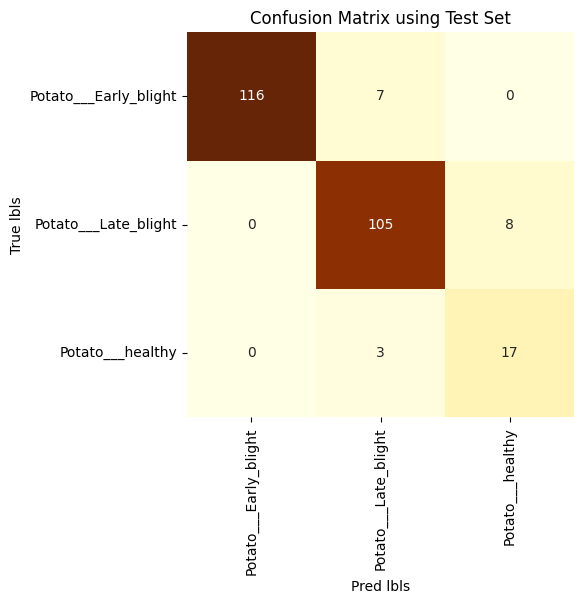

In [41]:
plt.figure(figsize=(5, 5))
sns.heatmap(cf_matrix, annot=True, fmt='g',
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, cmap='YlOrBr')
plt.xlabel('Pred lbls')
plt.ylabel('True lbls')
plt.title(cf_matrix_title)
plt.show()

In [36]:
pred_sums = np.sum(cf_matrix, axis=0)
prec_matrix = cf_matrix / pred_sums
precs = prec_matrix.diagonal()

# getting recalls
true_sums = np.sum(cf_matrix, axis=1)
recall_matrix = cf_matrix / true_sums
recalls = recall_matrix.diagonal()

# getting f1 measures
f1s = (2 * precs * recalls) / (precs + recalls)

In [37]:
counts_tbl = []
for i in range(len(class_names)):
    counts_tbl.append([class_names[i], true_sums[i]])
counts_tbl.append(['Test set', sum(true_sums)])

print('Test set counts:')
print(tabulate(counts_tbl, tablefmt='grid'))

Test set counts:
+-----------------------+-----+
| Potato___Early_blight | 123 |
+-----------------------+-----+
| Potato___Late_blight  | 113 |
+-----------------------+-----+
| Potato___healthy      |  20 |
+-----------------------+-----+
| Test set              | 256 |
+-----------------------+-----+


In [38]:
evals_df = pd.DataFrame(data={'Precision': precs, 'Recall': recalls, 'F1': f1s},
                        index=class_names)
pd.options.display.float_format = '{:.2%}'.format
evals_df

,Precision,Recall,F1
Potato___Early_blight,100.00%,94.31%,97.07%
Potato___Late_blight,91.30%,92.92%,92.11%
Potato___healthy,68.00%,85.00%,75.56%


In [39]:
macro_f1 = round(evals_df['F1'].mean() * 100, 2)
micro_f1 = round(np.sum(cf_matrix.diagonal()) / np.sum(cf_matrix) * 100, 2)
print(f'Macro F1: {macro_f1}%')
print(f'Micro F1: {micro_f1}%')

Macro F1: 88.24%
Micro F1: 92.97%


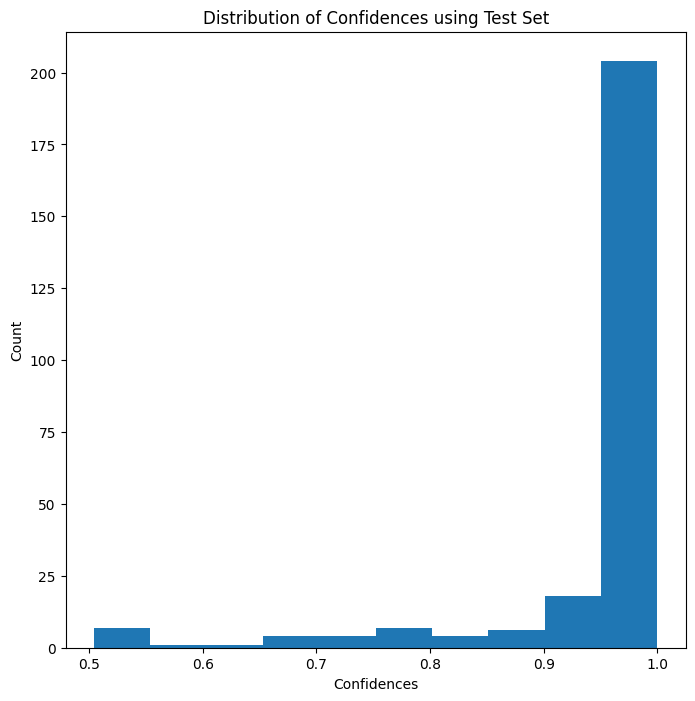

In [40]:
plt.figure(figsize=(8, 8))
plt.hist(pred_confs)
plt.xlabel('Confidences')
plt.ylabel('Count')
plt.title('Distribution of Confidences using Test Set')
plt.show()